<a href="https://colab.research.google.com/github/bcsrn/RL_DDPG_Recommendation/blob/master/RL_ActorCritic_DDPG_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Load, Env Setup


In [0]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Dependencies
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader
import itertools
import torch


In [0]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open('/content/gdrive/My Drive/RLProject/Data/ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('/content/gdrive/My Drive/RLProject/Data/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('/content/gdrive/My Drive/RLProject/Data/ml-1m/movies.dat',encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [0]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df = R_df.astype(int)

In [0]:
#might be used in the user dependednt state representation
userids = list(R_df.index.values) #list of userids
idx_to_userids = {i:userids[i] for i in range(len(userids))}
userids_to_idx = {userids[i]:i for i in range(len(userids))}

In [0]:
#list of movie ids
columns = list(R_df)
idx_to_id = {i:columns[i] for i in range(len(columns))}
id_to_idx = {columns[i]:i for i in range(len(columns))}

In [0]:
#to get item embeddings
#R_df[userid][movieid]

##Getting Embeddings of User and Item(Movie Id's)


In [0]:
R = R_df.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [0]:
#Movie Embeddings
U, sigma, Vt = svds(R_demeaned, k = 100)
# print(Vt.shape)
V = Vt.transpose()
# print(V.shape)
movie_list = V.tolist()
movie_embeddings_dict = {columns[i]:tf.convert_to_tensor(movie_list[i]) for i in range(len(columns))}

In [0]:
user_list = U.tolist()
user_embeddings_dict =  {userids[i]:tf.convert_to_tensor(user_list[i]) for i in range(len(userids))}

In [0]:
#prepare_dataset
#using ratings_df
users_df = ratings_df.sort_values(["UserID","Timestamp"]).set_index("UserID").fillna(0).drop("Timestamp",axis=1)
users = dict(tuple(users_df.groupby("UserID")))


##Train and Test Dataset

In [0]:
#Getting users with positive rating count greater than 10
# 10 == 'N' positively interacted items
from collections import defaultdict
from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
  rating_freq = Counter(users[user_id]["Rating"].values)
  if rating_freq['4']+rating_freq['5']<10 :
    continue
  else:
    users_id_list.add(user_id)
    users_dict[user_id]["item"] = users[user_id]["MovieID"].values
    users_dict[user_id]["rating"] = users[user_id]["Rating"].values
  


In [0]:
users_id_list = np.array(list(users_id_list))

In [0]:
#choosing default train_test_split of 25%
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

['1547' '2723']


In [0]:
print(test_users[:2])

['2122' '3364']


In [0]:
from torch.utils.data import Dataset
class UserDataset(Dataset):
  def __init__(self,users_list,users_dict):
    self.users_list = users_list
    self.users_dict = users_dict

  def __len__(self):
    return len(self.users_list)

  def __getitem__(self,idx):
    user_id = self.users_list[idx]
    items = [('1',)]*10
    ratings = [('0',)]*10
    j=0
    for i,rate in enumerate(self.users_dict[user_id]["rating"]):
      if int(rate) >3 and j < 10:
        items[j] = self.users_dict[user_id]["item"][i]
        ratings[j] = self.users_dict[user_id]["rating"][i]
        j += 1
    # item = list(self.users_dict[user_id]["item"][:])
    # rating = list(self.users_dict[user_id]["rating"][:])
    size = len(items)
    
    return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}


In [0]:
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

In [0]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_users_dataset,batch_size=1)
test_dataloader = DataLoader(test_users_dataset,batch_size=1)

In [0]:
train_num = len(train_dataloader)
print(train_num)

4462


#State Representation Models

In [0]:
def drrave_state_rep(userid_b,items,memory,idx):
  user_num = idx
  H = [] #item embeddings
  user_n_items = items
  user_embeddings = torch.Tensor(np.array(user_embeddings_dict[userid_b[0]]),).unsqueeze(0)
  for i,item in enumerate(user_n_items):
    H.append(np.array(movie_embeddings_dict[item[0]]))
  avg_layer = nn.AvgPool1d(1)
  item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
  state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])
  return state #state tensor shape [21,100]



In [0]:
def drru_state_rep(userid_b,items,memory,idx):
  user_num = idx
  H = []
  user_n_items = items
  user_embeddings = user_embeddings_dict[userid_b[0]]
  for i,item in enumerate(user_n_items):
    ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
    H.append(ui)

  pairs = list(itertools.combinations(memory[user_num], 2))
  for item1,item2 in pairs:
    pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
    pair2 = np.array(movie_embeddings_dict[str(int(item2))])

    product = pair1*pair2
    H.append(product)
  state = torch.Tensor(H,)
  return state #state tensor shape [55,100]


In [0]:
def drrp_state_rep(items,memory,idx):
  user_num = idx
  H = []
  user_n_items = items
  for i,item in enumerate(user_n_items):
    H.append(np.array(movie_embeddings_dict[item[0]]))
  
  pairs = list(itertools.combinations(memory[user_num], 2))
  for item1,item2 in pairs:
    pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
    pair2 = np.array(movie_embeddings_dict[str(int(item2))])
    product = pair1*pair2
    H.append(product)
  state = torch.Tensor(H,)
  return state

In [0]:
# just n items and their embeddings used to represent state
def state_rep(item_b):
  state = []
  user_embeddings = np.zeros((len(columns),100))
  movie_ids = list(item[0] for item in item_b)
  for i,subitem in enumerate(user_embeddings):
    if idx_to_id[i] in movie_ids:
      user_embeddings[i] = np.array(movie_embeddings_dict[idx_to_id[i]])
    else:
      user_embeddings[i] = np.zeros((100,))
  state = torch.Tensor(user_embeddings,)
  return torch.reshape(state,[-1]) 

#Actor, Critic Module

In [0]:
!pip install git+https://github.com/pabloppp/pytorch-tools@0.2.4 -U

  Cloning https://github.com/pabloppp/pytorch-tools (to revision 0.2.4) to /tmp/pip-req-build-ryzkfew0
  Running command git clone -q https://github.com/pabloppp/pytorch-tools /tmp/pip-req-build-ryzkfew0
  Running command git checkout -q 86c73996537002ab29e7e40f925cb90756f58156
  Created wheel for torchtools: filename=torchtools-0.2.4-cp36-none-any.whl size=19201 sha256=b01aa5dbbdc0fd333823de535e912a8abdc3f2d9f313c49f2960f9d2b140abb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsyf4x7c/wheels/98/e6/12/fbea7d7f60c85f3eeca5f5253cf77eab1a4fd352ea495ff3b9
Successfully built torchtools


In [0]:
#Dependencies

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtools.optim import Ranger
import tqdm
import random
import matplotlib.pyplot as plt


To use this log_lamb_rs, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results


In [0]:
#Actor Model:
#Generating an action a based on state s

class Actor(torch.nn.Module):
  def __init__(self, input_dim, output_dim,hidden_dim):
    super(Actor, self).__init__()

    self.drop_layer = nn.Dropout(p=0.5)        
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
  

  def forward(self, state):
    # state = self.state_rep(state)
    x = F.relu(self.linear1(state))
    # print(x.shape)
    x = self.drop_layer(x)
    x = F.relu(self.linear2(x))
    # print(x.shape)
    x = self.drop_layer(x)
    # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
    x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
    # return state, x
    return x
      




In [0]:
class Critic(nn.Module):
  def __init__(self,input_dim,output_dim,hidden_dim):

    super(Critic, self).__init__()
        
    self.drop_layer = nn.Dropout(p=0.5)
    
    self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, 1)

  def forward(self,state,action):    
    x = torch.cat([state, action], 1)
    # print(x.shape)
    x = F.relu(self.linear1(x))
    x = self.drop_layer(x)
    x = F.relu(self.linear2(x))
    x = self.drop_layer(x)
    x = self.linear3(x)
    return x



In [0]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # print(batch)
        state, action, reward, next_state = map(np.stack,zip(*batch))
        return state, action, reward, next_state
    
    def __len__(self):
        return len(self.buffer)

In [0]:
device = 'cpu'
# cuda = torch.device('cuda')

In [0]:
#used for plotting purposes
p_loss = []
v_loss = []

In [0]:
def ddpg_update(batch_size=1, 
                gamma = 0.6,
                min_value=-np.inf,
                max_value=np.inf,
                soft_tau=1e-2):
    
    state, action, reward, next_state = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(state).to(device)

    next_state = torch.FloatTensor(next_state).to(device)

    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    # print(state.shape)
    # print(policy_net(state).shape)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    p_loss.append(policy_loss)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    # print("1")
    value_loss = value_criterion(value, expected_value.detach())
    # print("2")
    v_loss.append(value_loss)
    policy_optimizer.zero_grad()
    # print("3")
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [0]:
#initializing actor and critic networks for drru and drrp state representation

value_net = Critic(5500,100,256)
policy_net = Actor(5500,100,256)

target_value_net = Critic(5500,100,256)
target_policy_net = Actor(5500,100,256)


target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
  target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
  target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

In [0]:
#initializing for drrave state representation

value_net = Critic(2100,100,256)
policy_net = Actor(2100,100,256)

target_value_net = Critic(2100,100,256)
target_policy_net = Actor(2100,100,256)


target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
  target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
  target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

In [0]:
print(policy_net)

Actor(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=5500, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=100, bias=True)
)


In [0]:
replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

memory = np.ones((train_num,10))*-1

In [0]:
def get_action(state,action_emb,userid_b,item_b,preds):
  action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0)
  item_embedding = []
  for movie in users_dict[userid_b[0]]["item"]:  
    item_embedding.append(np.array(movie_embeddings_dict[movie]))
  item_embedding = torch.Tensor(item_embedding,)
  items = item_embedding.T.unsqueeze(0)
  m = torch.bmm(action_emb,items).squeeze(0)
  sorted_m,indices = torch.sort(m,descending=True)
  index_list = list(indices[0])
  for i in index_list:
    if users_dict[userid_b[0]]["item"][i] not in preds:    
      preds.add(users_dict[userid_b[0]]["item"][i])
      return int(i)
 

In [0]:
def update_memory(memory,action,idx):
  memory[idx] = list(memory[idx,1:])+[action]

In [0]:
rate = 0

#Training

In [0]:
preddict = dict()
it = iter(train_dataloader)
for episode in tqdm.tqdm(range(train_num-1)):    
  batch_size= 1
  preds = set()
  first = next(it)
  item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
  memory[idx_b] = [item[0] for item in item_b]
  state = drrave_state_rep(userid_b,item_b,memory,idx_b)
  for j in range(5):    
    state_rep =  torch.reshape(state,[-1])
    action_emb = policy_net(state_rep)
    action = get_action(state,action_emb,userid_b,item_b,preds)
    rate = int(users_dict[userid_b[0]]["rating"][action])
    try:
      ratings = (int(rate)-3)/2
    except:
      ratings = 0
    reward = torch.Tensor((ratings,))

    if reward > 0:
      update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)

    next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    next_state_rep = torch.reshape(next_state,[-1])
    replay_buffer.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy())
    if len(replay_buffer) > batch_size:
        ddpg_update()

    state = next_state
  preddict[userid_b[0]] = preds


100%|██████████| 4461/4461 [07:43<00:00,  9.63it/s]


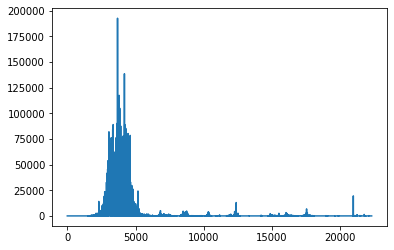

In [0]:
plt.plot(v_loss)

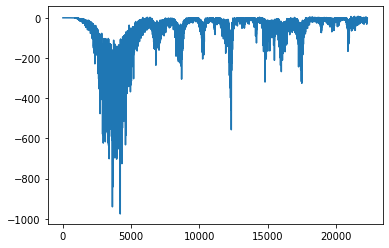

In [0]:
plt.plot(p_loss)

#Testing

In [0]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
test_pred_dict = dict()
for j in range(len(test_dataloader)-1):
  first = next(it2)
  item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
  memory[idx_b] = [item[0] for item in item_b]
  state = drrave_state_rep(userid_b,item_b,memory,idx_b)
  count = 0
  test_pred = set()
  for j in range(5):
    state_rep =  torch.reshape(state,[-1])
    action_emb = policy_net(state_rep)
    action = get_action(state,action_emb,userid_b,item_b,test_pred)
    rate = int(users_dict[userid_b[0]]["rating"][action])
    try:
      rating = (int(rate)-3)/2
    except:
      rating = 0
    reward = torch.Tensor((rating,))

    if reward > 0:
      count += 1
      update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
    next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    state = next_state
  precision += count/5
  test_pred_dict[userid_b[0]] = test_pred
print("p",precision/(len(test_dataloader)-1))

p 0.752925353059846


#Saving and Loading Models

In [0]:
PATH = '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'
torch.save(policy_net.state_dict(), PATH)

In [0]:
value_PATH = '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'
torch.save(value_net.state_dict(), value_PATH)

tpolicy_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetpolicy_net.pth'
torch.save(target_policy_net.state_dict(), tpolicy_PATH)

tvalue_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetvalue_net.pth'
torch.save(target_value_net.state_dict(), tvalue_PATH)


In [0]:
np.save('/content/gdrive/My Drive/RLProject/Models/train_dataloader',train_dataloader)
np.save('/content/gdrive/My Drive/RLProject/Models/test_dataloader',test_dataloader)

In [0]:
policy_net = Actor(5500,100,256)
policy_net.load_state_dict(torch.load(PATH))
policy_net.eval()

value_net = Critic(5500,100,256)
value_net.load_state_dict(torch.load(value_PATH))
value_net.eval()

target_policy_net = Actor(5500,100,256)
target_policy_net.load_state_dict(torch.load(tpolicy_PATH))
target_policy_net.eval()

target_value_net = Critic(5500,100,256)
target_value_net.load_state_dict(torch.load(tvalue_PATH))
target_value_net.eval()


Critic(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=370728, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load('/content/gdrive/My Drive/RLProject/Models/train_users.npy')

In [0]:
np.load = np_load_old